# EWX Forecasting Walkthrough

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json
import math
from collections import deque
import EWX_forecast as ewx
import pprint
import os

csv = "/home/jupyter-engiela/la-tools-test/EWX_Forecast/csv"

## Chose file to upload

In [2]:
files = ewx.sortdir(csv, 10)

files found in dir:  C:\Users\wb5888\LA-tools\EWX_Forecast\csv
                                       files                time
0  NEPOOL_PSNH_80019500349_CH3_timeshift.csv 2019-07-09 11:11:52
1        NEPOOL_PSNH_80019500349_CH3_val.csv 2019-07-09 11:09:47
2            NEPOOL_PSNH_80019500349_CH3.csv 2019-07-09 10:41:47
3        NEPOOL_MECO_3840191016_load_adj.csv 2019-07-08 09:28:18
4       NEPOOL_MECO_3840191016_timeshift.csv 2019-07-08 09:24:22
5             NEPOOL_MECO_3840191016_val.csv 2019-07-08 09:24:21
6                    MECO_3840191016_SCA.csv 2019-07-08 09:23:20
7                 NEPOOL_MECO_3840191016.csv 2019-07-08 09:22:25
8        NEPOOL_MECO_7655366016_load_adj.csv 2019-07-08 09:12:07
9             NEPOOL_MECO_7655366016_SCA.csv 2019-07-05 14:28:03


In [3]:
myfile = files.files[2]
print('working with {}'.format(myfile))

working with NEPOOL_PSNH_80019500349_CH3.csv


## Import & plot

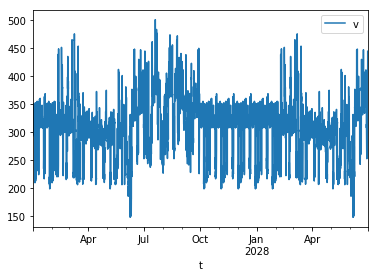

In [4]:
idr = pd.read_csv(myfile)
idr.columns = ['t', 'v']
idr['v'] = pd.to_numeric(idr['v'], errors = 'coerce')
idr.t = pd.to_datetime(idr.t)
idr.set_index(pd.DatetimeIndex(idr.t), inplace = True, drop = True)
idr = idr.drop('t', axis = 1)
idr.plot(y = 'v')

# Default IDR Config

## Periodic Zeros
1. threshold (less than this is considered zero) 
2. periodicity percent (percent of time weekdays have to be zero to be nonperiodic)

In [14]:
#check for nonperiodic zeros
tmp2 = ewx.periodic_zero(idr, .01, 1)
tmp2.head()

,v,d,h,pz,lr
t,,,,,
2027-01-01 01:00:00,299.5125,4,1,0.0,False
2027-01-01 02:00:00,300.6500,4,2,0.0,False
2027-01-01 03:00:00,303.3625,4,3,0.0,False
2027-01-01 04:00:00,308.6125,4,4,0.0,False
2027-01-01 05:00:00,312.9000,4,5,0.0,False


## Interval Gap Check
1. checks time differences (expects to be one hour)

In [6]:
tmp2['mon'] = [a.month for a in tmp2.index]
 
#get value & time differences
tmp2 = ewx.interval_gap_check(tmp2)
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap
t,,,,,,,,,
2027-01-01 01:00:00,299.5125,4,1,0.0,False,1,0.0000,1.0,False
2027-01-01 02:00:00,300.6500,4,2,0.0,False,1,1.1375,1.0,False
2027-01-01 03:00:00,303.3625,4,3,0.0,False,1,2.7125,1.0,False
2027-01-01 04:00:00,308.6125,4,4,0.0,False,1,5.2500,1.0,False
2027-01-01 05:00:00,312.9000,4,5,0.0,False,1,4.2875,1.0,False


## Variance Validation
1. time window to calculate rolling statistics
2. should window be centered
3. number of standard deviations used to flag spikes & dips

In [7]:
#check spikes & dips
#time_window = int(60*24*3600/hb)
time_window = int(30*24)
centered = True
n_sd = 4

tmp2 = ewx.variance_validation(tmp2, time_window, centered, 2)
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap,rm,mc,crm,crsd,var,spike,dip
t,,,,,,,,,,,,,,,,
2027-01-01 01:00:00,299.5125,4,1,0.0,False,1,0.0000,1.0,False,308.562188,-9.049688,3.646773,36.732031,-3.481561,False,False
2027-01-01 02:00:00,300.6500,4,2,0.0,False,1,1.1375,1.0,False,308.573961,-7.923961,3.662995,36.682273,-3.163246,False,False
2027-01-01 03:00:00,303.3625,4,3,0.0,False,1,2.7125,1.0,False,308.609841,-5.247341,3.703324,36.639467,-2.416927,False,False
2027-01-01 04:00:00,308.6125,4,4,0.0,False,1,5.2500,1.0,False,308.647934,-0.035434,3.745876,36.597806,-1.009459,False,False
2027-01-01 05:00:00,312.9000,4,5,0.0,False,1,4.2875,1.0,False,308.665385,4.234615,3.767788,36.549752,0.123900,False,False


## DST Check, Fix Nonhourly Intervals, Flag NA
1. missing hour in March window or extra in Nov window - cleans
2. adjusts nonhourly data
3. flags values that were initially missing

In [8]:
#check for dst (missing hour 3/8-3/14 and extra value 11/1-11/7)
tmp2 = ewx.dst_check(tmp2)
tmp2 = ewx.fix_interval(tmp2)
tmp2['na'] = [v == .123456789 for v in tmp2['v']]
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap,rm,mc,crm,crsd,var,spike,dip,dst,min,date_zip,na
2027-01-01 01:00:00,299.5125,4,1,0.0,False,1,0.0000,1.0,False,308.562188,-9.049688,3.646773,36.732031,-3.481561,False,False,False,0,"(4, 1)",False
2027-01-01 02:00:00,300.6500,4,2,0.0,False,1,1.1375,1.0,False,308.573961,-7.923961,3.662995,36.682273,-3.163246,False,False,False,0,"(4, 2)",False
2027-01-01 03:00:00,303.3625,4,3,0.0,False,1,2.7125,1.0,False,308.609841,-5.247341,3.703324,36.639467,-2.416927,False,False,False,0,"(4, 3)",False
2027-01-01 04:00:00,308.6125,4,4,0.0,False,1,5.2500,1.0,False,308.647934,-0.035434,3.745876,36.597806,-1.009459,False,False,False,0,"(4, 4)",False
2027-01-01 05:00:00,312.9000,4,5,0.0,False,1,4.2875,1.0,False,308.665385,4.234615,3.767788,36.549752,0.123900,False,False,False,0,"(4, 5)",False


# Flag Errors

In [9]:
data_filter = [a or b or c or d or e for a, b, c, d, e in zip(tmp2.lr, tmp2.gap, tmp2.spike, tmp2.dip, tmp2.na)]
tmp2['err'] = data_filter
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap,rm,...,crm,crsd,var,spike,dip,dst,min,date_zip,na,err
2027-01-01 01:00:00,299.5125,4,1,0.0,False,1,0.0000,1.0,False,308.562188,...,3.646773,36.732031,-3.481561,False,False,False,0,"(4, 1)",False,False
2027-01-01 02:00:00,300.6500,4,2,0.0,False,1,1.1375,1.0,False,308.573961,...,3.662995,36.682273,-3.163246,False,False,False,0,"(4, 2)",False,False
2027-01-01 03:00:00,303.3625,4,3,0.0,False,1,2.7125,1.0,False,308.609841,...,3.703324,36.639467,-2.416927,False,False,False,0,"(4, 3)",False,False
2027-01-01 04:00:00,308.6125,4,4,0.0,False,1,5.2500,1.0,False,308.647934,...,3.745876,36.597806,-1.009459,False,False,False,0,"(4, 4)",False,False
2027-01-01 05:00:00,312.9000,4,5,0.0,False,1,4.2875,1.0,False,308.665385,...,3.767788,36.549752,0.123900,False,False,False,0,"(4, 5)",False,False


# Interpolate Error Values

In [10]:
tmp2['interp'] = ewx.interp(tmp2.v, tmp2.err)
    
linear = tmp2.interp.interpolate(method = 'linear', axis = 0, in_place = False, limit_direction = 'forward')
tmp2['lin'] = linear
tmp2.lin[tmp2.lin.isnull()] = tmp2.v[tmp2.lin.isnull()]
tmp2.head()

c:\users\wb5888\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,v,d,h,pz,lr,mon,vd,td,gap,rm,...,var,spike,dip,dst,min,date_zip,na,err,interp,lin
2027-01-01 01:00:00,299.5125,4,1,0.0,False,1,0.0000,1.0,False,308.562188,...,-3.481561,False,False,False,0,"(4, 1)",False,False,299.5125,299.5125
2027-01-01 02:00:00,300.6500,4,2,0.0,False,1,1.1375,1.0,False,308.573961,...,-3.163246,False,False,False,0,"(4, 2)",False,False,300.6500,300.6500
2027-01-01 03:00:00,303.3625,4,3,0.0,False,1,2.7125,1.0,False,308.609841,...,-2.416927,False,False,False,0,"(4, 3)",False,False,303.3625,303.3625
2027-01-01 04:00:00,308.6125,4,4,0.0,False,1,5.2500,1.0,False,308.647934,...,-1.009459,False,False,False,0,"(4, 4)",False,False,308.6125,308.6125
2027-01-01 05:00:00,312.9000,4,5,0.0,False,1,4.2875,1.0,False,308.665385,...,0.123900,False,False,False,0,"(4, 5)",False,False,312.9000,312.9000


# Write Validated Data

In [11]:
#final validated data

print('writing validated data to .csv...')
final = tmp2.copy()
val = myfile.split('.')[0]
val_file = ''.join([val, '_val.csv'])
final.to_csv(val_file, header = True, index = True)
print('wrote {} to {}.'.format(val_file, os.getcwd()))

writing validated data to .csv...
wrote NEPOOL_PSNH_80019500349_CH3_val.csv to C:\Users\wb5888\LA-tools\EWX_Forecast\csv.


# Timeshift/Forecast
1. shift validated data *years* in the future

In [12]:
forecast = ewx.timeshift(final, 10)
    
print('writing forecasts to .csv...')
name = myfile.split('.')[0]
ts_name = '_'.join([name, 'timeshift'])
ts_name = '.'.join([ts_name, 'csv'])
forecast.to_csv(ts_name, header = False)
print('wrote {} to {}.'.format(ts_name, os.getcwd()))
forecast.head()

C:\Users\wb5888\LA-tools\EWX_Forecast\EWX_forecast.py:368: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  master = pd.concat([year_data, future], axis = 0)


forecasted year 0 of 1 with 8736 reads.
forecasted year 1 of 1 with 8736 reads.
writing forecasts to .csv...
wrote NEPOOL_PSNH_80019500349_CH3_timeshift.csv to C:\Users\wb5888\LA-tools\EWX_Forecast\csv.


C:\Users\wb5888\LA-tools\EWX_Forecast\EWX_forecast.py:380: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  master = pd.concat([master, forecast], axis = 0)


,v
2027-07-02 00:00:00,283.5000
2027-07-02 01:00:00,339.0625
2027-07-02 02:00:00,348.2500
2027-07-02 03:00:00,356.5625
2027-07-02 04:00:00,362.2500


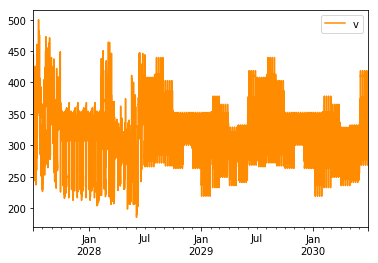

In [13]:
forecast.plot(y = 'v', color = 'darkorange')